In [1]:
import sys
import os

# 获取当前 Notebook 的路径
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 获取上一级目录
parent_dir = os.path.dirname(current_dir)

# 添加上一级目录到 sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import read_jsonl

In [3]:
import os
import time
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from functools import partial
from eap.metrics import logit_diff
from eap.graph import Graph
from eap.dataset import EAPDataset
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline, get_circuit_logits

In [4]:
revised_entity_first_token_accuracy = [
    0.101226397,
    0.098306405,
    0.104146389,
    0.105898384,
    0.103951723,
    0.102978392,
    0.103562391,
    0.107845046,
    0.11115437,
    0.12380767,
    0.169554215,
    0.241386023,
    0.321977808,
    0.428265525,
    0.510609305,
    0.577379794,
    0.639283629,
    0.692816819,
    0.721822075,
    0.752189994,
    0.774381935,
    0.79637921,
    0.819933814,
    0.832003115,
    0.852053728,
    0.866653689,
    0.874245669,
    0.885925638,
    0.892933619,
    0.89741094,
    0.904613588,
    0.913762897,
    0.911426903,
    0.915904224,
    0.913762897,
    0.919018883,
    0.920381546,
    0.926026864,
    0.928362858,
    0.922522873,
    0.926026864,
    0.925637532,
    0.925832198,
    0.922328207,
    0.934202842,
    0.926416196,
    0.930893518,
    0.923885536,
    0.923496204
]

In [5]:
new_entity_first_token_accuracy = [
    0.10254407,
    0.100835002,
    0.104204307,
    0.104594951,
    0.103178866,
    0.107231798,
    0.104692612,
    0.104448459,
    0.11025929,
    0.115435324,
    0.122906392,
    0.148298257,
    0.173934274,
    0.230480004,
    0.287172225,
    0.346989599,
    0.416524244,
    0.480785195,
    0.530348162,
    0.58288979,
    0.628302163,
    0.664094927,
    0.702475707,
    0.729332487,
    0.753943064,
    0.78045803,
    0.793105132,
    0.811709556,
    0.829093217,
    0.83319498,
    0.846721031,
    0.861077201,
    0.865471947,
    0.874749744,
    0.879535134,
    0.886371405,
    0.890229015,
    0.899457981,
    0.905024659,
    0.900727575,
    0.900825236,
    0.905415303,
    0.903803897,
    0.908198643,
    0.909321744,
    0.908247473,
    0.911860931,
    0.915376727,
    0.916988134
]

In [6]:
x_coords = np.arange(len(new_entity_first_token_accuracy)) / (len(new_entity_first_token_accuracy) - 1) * 14

In [7]:
directory_path="../outputs/train/gpt2-medium/2024-12-19-18-08-58/checkpoints"
subdirectories = [
    name for name in os.listdir(directory_path)
    if os.path.isdir(os.path.join(directory_path, name))
]

In [8]:
new_entity_result_matrix = []
revised_entity_result_matrix = []
to_delete = []
for dir_name in subdirectories:
    prediction_file = os.path.join(directory_path, dir_name, "prediction.jsonl")
    if not os.path.exists(prediction_file):
        print(f"Prediction file not found for directory '{dir_name}'")
        to_delete.append(dir_name)
    else:
        print(f"Reading prediction file for directory '{dir_name}'")
        predictions = read_jsonl(prediction_file)
        N = len(predictions)
        new_entity_num = int(0.5 * N)
        new_entity_result = [pred["correct"] for pred in predictions][:new_entity_num]
        new_entity_result_matrix.append(new_entity_result)
        revised_entity_result = [pred["correct"] for pred in predictions][new_entity_num:]
        revised_entity_result_matrix.append(revised_entity_result)

for dir_name in to_delete:
    subdirectories.remove(dir_name)

Reading prediction file for directory 'checkpoint-163'
Reading prediction file for directory 'checkpoint-489'
Reading prediction file for directory 'checkpoint-1469'
Reading prediction file for directory 'checkpoint-2445'
Reading prediction file for directory 'checkpoint-2285'
Reading prediction file for directory 'checkpoint-1795'
Reading prediction file for directory 'checkpoint-1306'
Reading prediction file for directory 'checkpoint-326'
Reading prediction file for directory 'checkpoint-816'
Reading prediction file for directory 'checkpoint-2122'
Reading prediction file for directory 'checkpoint-653'
Reading prediction file for directory 'checkpoint-1142'
Reading prediction file for directory 'checkpoint-1959'
Reading prediction file for directory 'checkpoint-1632'
Reading prediction file for directory 'checkpoint-979'


In [9]:
indexes = sorted(range(len(subdirectories)), key=lambda i: int(subdirectories[i].split('-')[1]))

print("排序后的下标列表：", indexes)

排序后的下标列表： [0, 7, 1, 10, 8, 14, 11, 6, 2, 13, 5, 12, 9, 4, 3]


In [10]:
new_entity_result_matrix = [new_entity_result_matrix[i] for i in indexes]
new_entity_result_matrix = np.array(new_entity_result_matrix)
revised_entity_result_matrix = [revised_entity_result_matrix[i] for i in indexes]
revised_entity_result_matrix = np.array(revised_entity_result_matrix)

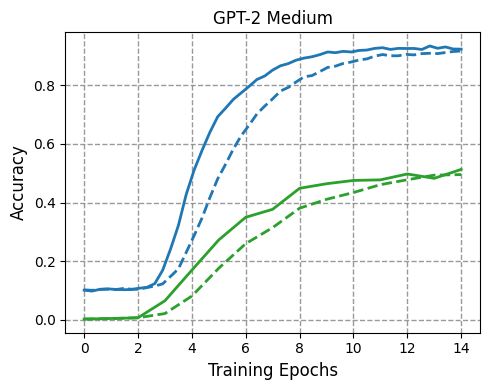

In [11]:
new_entity_accuracy = np.mean(new_entity_result_matrix, axis=1)
revised_entity_accuracy = np.mean(revised_entity_result_matrix, axis=1)

plt.figure(figsize=(5, 4))
plt.plot(x_coords, revised_entity_first_token_accuracy, label='First-token Acc (K_rel)', linewidth=2, color='C0')
plt.plot(x_coords, new_entity_first_token_accuracy, label='First-token Acc (K_compl)', linewidth=2, color='C0', linestyle='--')
plt.plot(revised_entity_accuracy, label='Query Acc (K_rel)', linewidth=2, color='C2')
plt.plot(new_entity_accuracy, label='Query Acc (K_compl)', linewidth=2, color='C2', linestyle='--')

plt.title('GPT-2 Medium')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

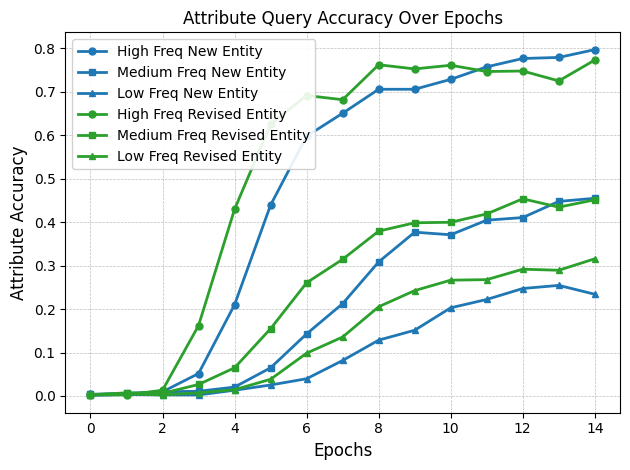

In [12]:
num_columns = new_entity_result_matrix.shape[1]  # 获取列数
num_columns_to_average = num_columns // 3

high_new_entity_accuracy = np.mean(new_entity_result_matrix[:, :num_columns_to_average], axis=1)
high_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, :num_columns_to_average], axis=1)

medium_new_entity_accuracy = np.mean(new_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)
medium_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)

low_new_entity_accuracy = np.mean(new_entity_result_matrix[:, -num_columns_to_average:], axis=1)
low_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, -num_columns_to_average:], axis=1)


plt.plot(high_new_entity_accuracy, label='High Freq New Entity', color='C0', marker='o', linewidth=2, markersize=5)
plt.plot(medium_new_entity_accuracy, label='Medium Freq New Entity', color='C0', marker='s', linewidth=2, markersize=5)
plt.plot(low_new_entity_accuracy, label='Low Freq New Entity', color='C0', marker='^', linewidth=2, markersize=5)

plt.plot(high_revised_entity_accuracy, label='High Freq Revised Entity', color='C2', marker='o', linewidth=2, markersize=5)
plt.plot(medium_revised_entity_accuracy, label='Medium Freq Revised Entity', color='C2', marker='s', linewidth=2, markersize=5)
plt.plot(low_revised_entity_accuracy, label='Low Freq Revised Entity', color='C2', marker='^', linewidth=2, markersize=5)

plt.title('Attribute Query Accuracy Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Attribute Accuracy', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [13]:
def reduce_array(arr, n):
    """
    将有序数组的元素减少到 n 个，均匀删减元素。

    参数:
    - arr: 原始有序数组
    - n: 缩减后的元素数量

    返回:
    - 新的缩减后数组
    """
    N = len(arr)
    if n >= N:
        return arr  # 如果需要的元素数量大于或等于原数组数量，则返回原数组

    # 计算步长 step，确保均匀删减
    step = N / n

    # 保留均匀分布的 n 个元素
    reduced_arr = [arr[int(i * step)] for i in range(n)]

    return reduced_arr

In [14]:
n = 1000
ensembeld_new_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in new_entity_result_matrix]
ensembeld_new_entity_result_matrix = np.array(ensembeld_new_entity_result_matrix)
ensembeld_new_entity_result_matrix.shape

(15, 200)

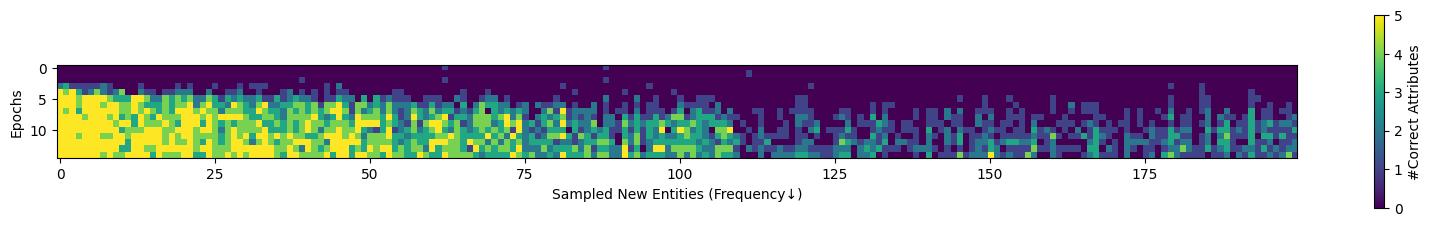

In [15]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_new_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled New Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [16]:
ensembeld_revised_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in revised_entity_result_matrix]
ensembeld_revised_entity_result_matrix = np.array(ensembeld_revised_entity_result_matrix)
ensembeld_revised_entity_result_matrix.shape

(15, 200)

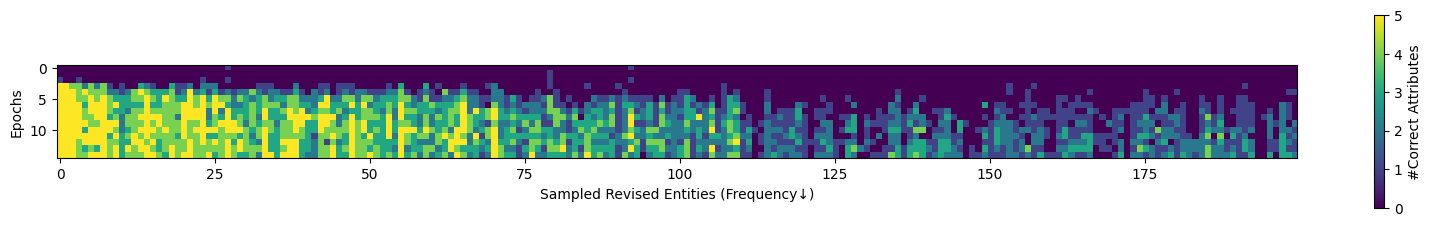

In [17]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_revised_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled Revised Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [18]:
hit_at_10_results = {
    "new": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    },
    "revised": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    }
}

topn = 20000
circuit_n = 300
for task in ["city"]:
    for index in tqdm(indexes):
        for source_type in ["new", "revised"]:
            for source_frequency in ["high", "medium", "low"]:
                for target_type in ["new", "revised"]:
                    for target_frequency in ["high", "medium", "low"]:
                        result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{source_type}", f"frequency_{source_frequency}", "method_EAP-IG", f"topn_{topn}", f"target_type_{target_type}", f"target_frequency_{target_frequency}", f"{task}_prediction.jsonl")
                        results = read_jsonl(result_file)
                        hit_at_10 = len([d for d in results if d["token_rank"] <= 9]) / len(results)
                        hit_at_10_results[source_type][source_frequency][target_type][target_frequency].append(hit_at_10)

100%|██████████| 15/15 [00:00<00:00, 20.95it/s]


In [19]:
k_type = {
    "new": "K_compl",
    "revised": "K_rel"
}

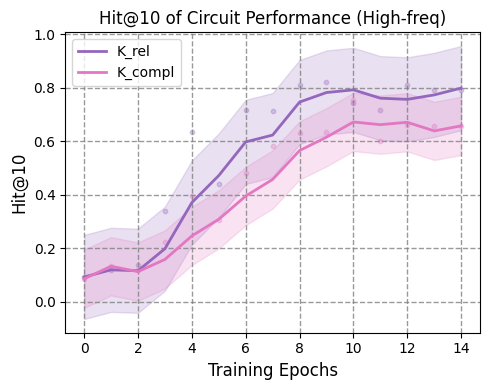

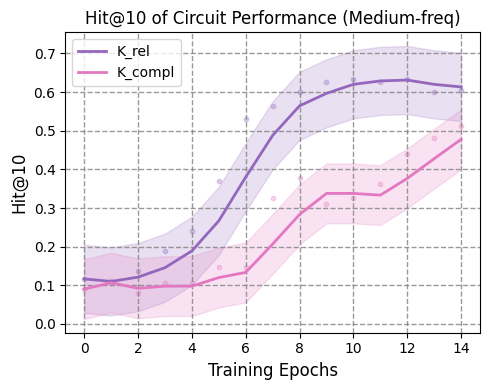

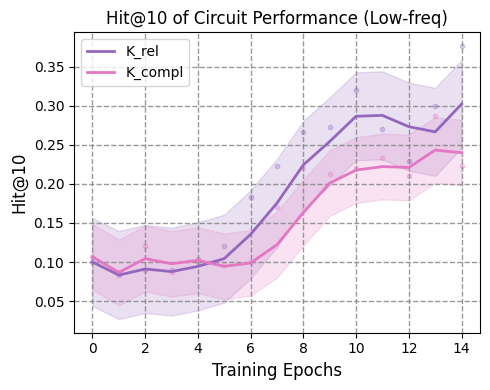

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_frequency in ["high", "medium", "low"]:
    plt.figure(figsize=(5, 4))
    color_cnt = 4
    for source_type in ["revised", "new"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]
        
        # # 定义核函数
        # kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))

        # # 拟合高斯过程回归模型
        # gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        # gp.fit(x[:, np.newaxis], y)

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)[:, np.newaxis]
        # y_fit, std_residuals = gp.predict(x_fit, return_std=True)

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)
        
        line, = plt.plot(x_fit.ravel(), y_fit, label=f'{k_type[source_type].capitalize()}', linewidth=2, color=f'C{color_cnt}')
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit.ravel(), y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)
        
        color_cnt += 2

    plt.title(f'Hit@10 of Circuit Performance ({source_frequency.capitalize()}-freq)', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

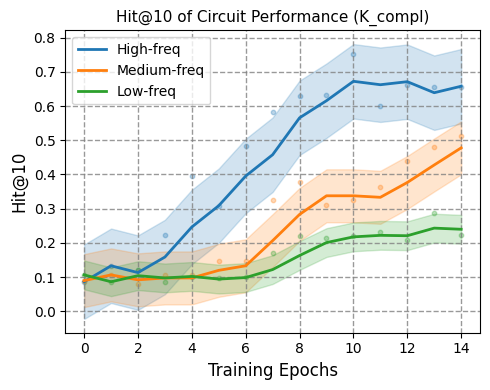

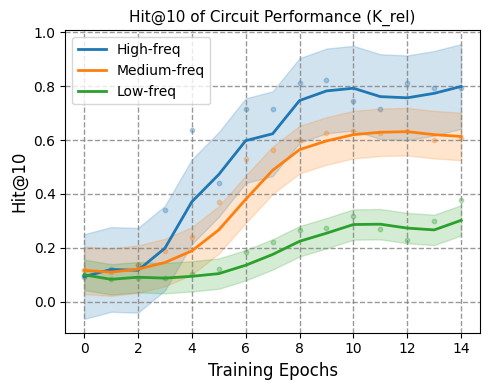

In [21]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_type in ["new", "revised"]:
    plt.figure(figsize=(5, 4))
    for source_frequency in ["high", "medium", "low"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)

        line, = plt.plot(x_fit, y_fit, label=f'{source_frequency.capitalize()}-freq', linewidth=2)
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit, y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)

    plt.title(f'Hit@10 of Circuit Performance ({k_type[source_type]})', fontsize=11)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

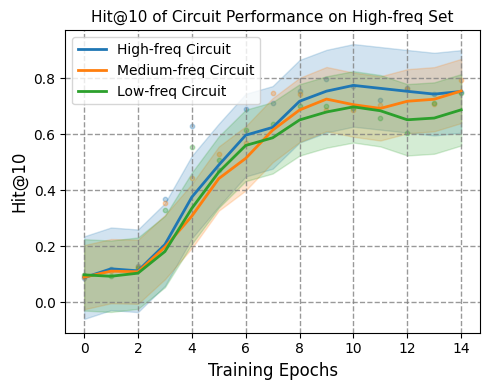

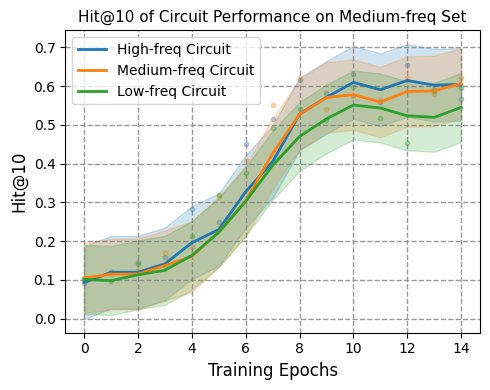

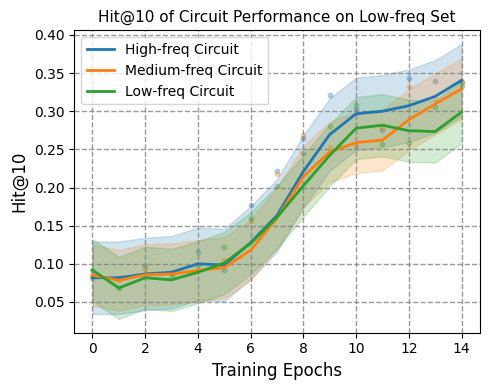

In [22]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for target_frequency in ["high", "medium", "low"]:
    plt.figure(figsize=(5, 4))
    target_type = source_type
    # target_frequency = source_frequency
    for source_frequency in ["high", "medium", "low"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        for source_type in ["new", "revised"]:
            for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
                y[i] += hit_at_10
            cnt += 1
        y = [v / cnt for v in y]
    
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)

        line, = plt.plot(x_fit, y_fit, label=f'{source_frequency.capitalize()}-freq Circuit', linewidth=2)
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit, y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)

    plt.title(f'Hit@10 of Circuit Performance on {target_frequency.capitalize()}-freq Set', fontsize=11)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [23]:
from collections import defaultdict

def create_performance_dict():
    return defaultdict(lambda: {"new": create_freq_dict(), "revised": create_freq_dict()})

def create_freq_dict():
    # 使用 lambda 递归创建嵌套字典结构
    return {"high": [], "medium": [], "low": []}

# 使用函数创建相同结构的嵌套字典
clean_baseline_performance = create_performance_dict()
circuit_performance = create_performance_dict()
corrupted_baseline_performance = create_performance_dict()
faithfulness_performance = create_performance_dict()
edge_entropy = create_performance_dict()
graph = create_performance_dict()

topn = 20000
circuit_n = 300
for index in tqdm(indexes):
    for task in ["city"]:
        for type in ["new", "revised"]:
            for freq in ["high", "medium", "low"]:
                result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_results.json")
                if os.path.exists(result_file):
                    results = json.load(open(result_file))
                    clean_baseline_performance[task][type][freq].append(results["clean_baseline_performance"])
                    circuit_performance[task][type][freq].append(results["circuit_performance"])
                    corrupted_baseline_performance[task][type][freq].append(results["corrupted_baseline_performance"])
                    faithfulness = (results["circuit_performance"] - results["corrupted_baseline_performance"]) / (results["clean_baseline_performance"] - results["corrupted_baseline_performance"]) if results["clean_baseline_performance"] > results["corrupted_baseline_performance"] else 0
                    faithfulness_performance[task][type][freq].append(faithfulness)
                    edge_entropy[task][type][freq].append(results["edge_entropy"])
                    g = Graph.from_pt(os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_graph.pt"))
                    graph[task][type][freq].append(g)
                else:
                    print(f"Result file '{result_file}' not found for directory '{subdirectories[index]}'")
                    clean_baseline_performance[task][type][freq].append(None)
                    circuit_performance[task][type][freq].append(None)
                    corrupted_baseline_performance[task][type][freq].append(None)
                    faithfulness_performance[task][type][freq].append(None)
                    edge_entropy[task][type][freq].append(None)
                    graph[task][type][freq].append(None)
            

100%|██████████| 15/15 [04:37<00:00, 18.47s/it]


In [24]:
def jaccard_similarity(a, b):
    """
    计算两个集合的 Jaccard 相似度。

    参数:
    - a: 集合 a
    - b: 集合 b

    返回:
    - Jaccard 相似度
    """
    set_a = set()
    for key, value in a.items():
        if value.in_graph:
             set_a.add(key)
    set_b = set()
    for key, value in b.items():
        if value.in_graph:
             set_b.add(key)
    return len(set_a & set_b) / len(set_a | set_b)

In [25]:
nodes_last_jaccard_similarity = create_performance_dict()
edges_last_jaccard_similarity = create_performance_dict()

for task in ["city"]:
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(1, len(indexes)):
                nodes_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].nodes, graph[task][type][freq][-1].nodes))
                edges_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].edges, graph[task][type][freq][-1].edges))

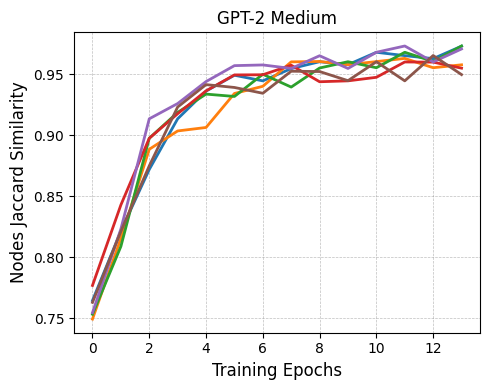

In [26]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(nodes_last_jaccard_similarity["city"]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, nodes_last_jaccard_similarity["city"][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Medium')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Nodes Jaccard Similarity', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

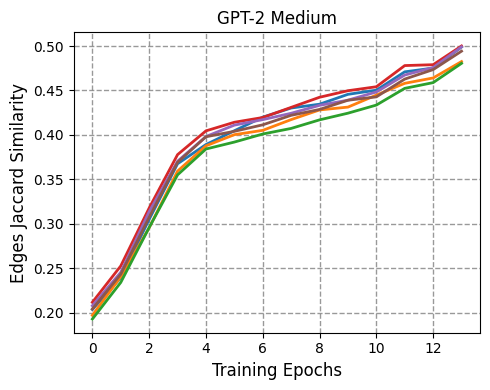

In [27]:
task = "city"

# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(edges_last_jaccard_similarity[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, edges_last_jaccard_similarity[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Medium')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Edges Jaccard Similarity', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

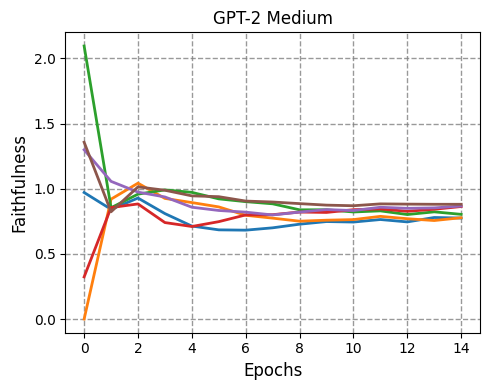

In [28]:
task = "city"

# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(clean_baseline_performance[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, faithfulness_performance[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Medium')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Faithfulness', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

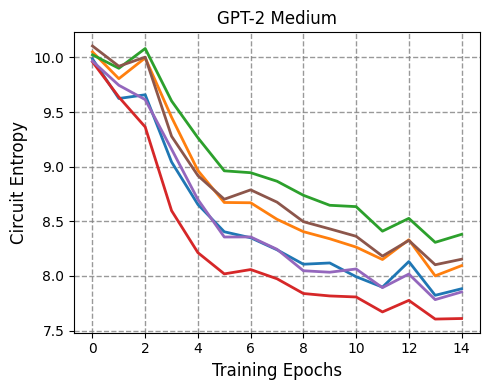

In [29]:
task = "city"

# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(clean_baseline_performance[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, edge_entropy[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Medium')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Circuit Entropy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [30]:
def count_edges_at_layers(g, activated=True):
    counter = [0 for i in range(g.cfg["n_layers"] )]
    for edge in g.edges.values():
        if activated and not edge.in_graph:
            continue
        counter[edge.parent.layer] += 1
    
    return counter

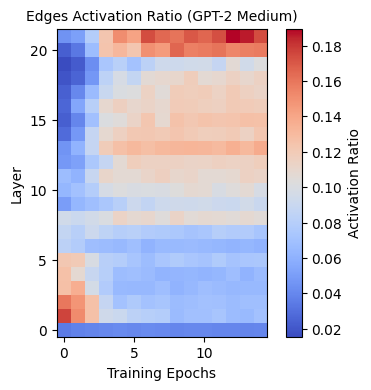

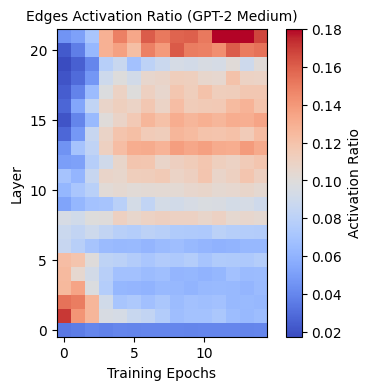

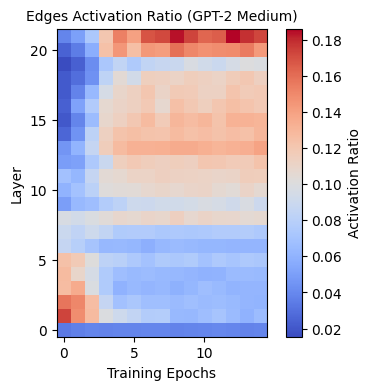

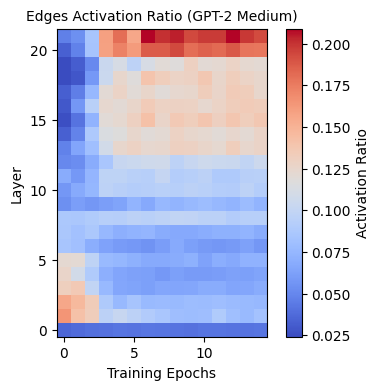

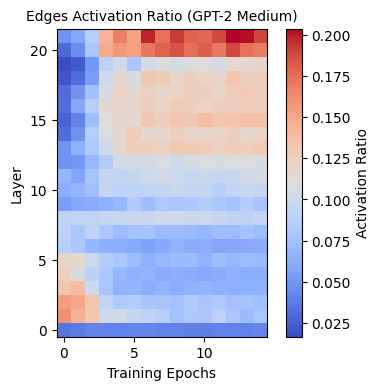

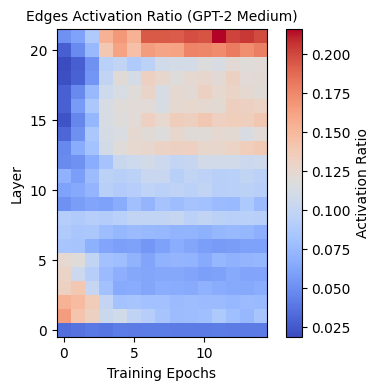

In [31]:
for task in ["city"]:
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            layer_distribution_matrix = []
            for i in range(len(indexes)):
                layer_distribution = np.array(count_edges_at_layers(graph[task][type][freq][i], activated=True)) / np.array(count_edges_at_layers(graph[task][type][freq][i], activated=False))
                layer_distribution_matrix.append(layer_distribution[:-2])

            layer_distribution_matrix = np.array(layer_distribution_matrix)

            # Set the figure size to increase x-axis width
            plt.figure(figsize=(5,4))  # Adjust width and height as needed

            im = plt.imshow(layer_distribution_matrix.T, cmap='coolwarm', interpolation='nearest')
            plt.title('Edges Activation Ratio (GPT-2 Medium)', fontsize=10)
            plt.ylabel('Layer')
            plt.xlabel('Training Epochs')
            cbar = plt.colorbar(im, shrink=1)
            cbar.set_label('Activation Ratio')
            # 反转 y 轴
            plt.gca().invert_yaxis()
            plt.yticks(np.arange(0, 23, 5))
            plt.show()

In [32]:
model = "gpt2-medium"
eval_data_file = f"/mnt/8t/oyx/KCPT/data/entities_50000/circuit_{circuit_n}/{model}/{task}.jsonl"

eval_data = read_jsonl(eval_data_file)
eval_data = [d for d in eval_data if d["type"] == type]
if freq == "high":
    eval_data = [d for d in eval_data if int(d["frequency"]) > 5]
elif freq == "medium":
    eval_data = [d for d in eval_data if 2 <= int(d["frequency"]) <= 5]
elif freq == "low":
    eval_data = [d for d in eval_data if int(d["frequency"]) == 1]

prompt_template = {
    "city": "{} lives in the city of",
    "major": "{} majors in the field of",
    "company": "{} works for the company of"
}

In [33]:
import random
import os
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from analyzer import ComponentAnalyzer

task = "city"
type = "new"
freq = "high"

def compute_average_of_ratios(ratio_list):
    if not ratio_list:
        return []  # 处理空列表情况
    # 直接累加并计算均值
    length = len(ratio_list)
    overall_ratio = [[0] * len(ratio_list[0][0]) for _ in range(len(ratio_list[0]))]
    
    for r in ratio_list:
        for l in range(len(r)):
            for h in range(len(r[l])):
                overall_ratio[l][h] += r[l][h]
    
    # 对每个元素求平均
    for l in range(len(overall_ratio)):
        for h in range(len(overall_ratio[l])):
            overall_ratio[l][h] /= length

    return overall_ratio

# Function to create circuit head sets based on graph
def create_circuit_head_set(overall_head_set):
    circuit_head_set = set()
    for l, h in overall_head_set:
        if g.nodes[f"a{l}.h{h}"].in_graph:
            circuit_head_set.add((l, h))
    return circuit_head_set

# Initialize lists
overall_DLA_subject_ratio_list = []
overall_DLA_relation_ratio_list = []
overall_subject_head_set_list = []
overall_relation_head_set_list = []
overall_mixed_head_set_list = []
circuit_subject_head_set_list = []
circuit_relation_head_set_list = []
circuit_mixed_head_set_list = []

# Loop over indexes
for index in tqdm(indexes):
    # Load model and tokenizer
    g = graph[task][type][freq][index]
    model_name_or_path = os.path.join(directory_path, subdirectories[index])
    hf_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    hooked_model = HookedTransformer.from_pretrained(
        model, device="cuda", fold_ln=False, center_writing_weights=False, center_unembed=False,
        hf_model=hf_model, tokenizer=tokenizer, local_path=model_name_or_path
    )
    
    # Configure hooked model
    hooked_model.cfg.use_split_qkv_input = True
    hooked_model.cfg.use_attn_result = True
    hooked_model.cfg.use_hook_mlp_in = True

    # Initialize temporary lists for this model
    DLA_subject_ratio_list = []
    DLA_relation_ratio_list = []

    # Process each data point (sample once before loop to avoid redundant random sampling)
    # sampled_data = random.sample(eval_data, 10)
    
    for datapoint in eval_data:
        analyzer = ComponentAnalyzer(hooked_model, prompt_template[task].format(datapoint["clean_subject"]),
                                     datapoint["clean_label"], datapoint["clean_subject"])
        DLA_subject_ratio, DLA_relation_ratio = analyzer.calculate_DLA_by_source()

        # Collect results
        DLA_subject_ratio_list.append(DLA_subject_ratio)
        DLA_relation_ratio_list.append(DLA_relation_ratio)
    
    # Append mean DLA ratios to overall lists
    average_DLA_subject_ratio = compute_average_of_ratios(DLA_subject_ratio_list)
    average_DLA_relation_ratio = compute_average_of_ratios(DLA_relation_ratio_list)
    overall_DLA_subject_ratio_list.append(average_DLA_subject_ratio)
    overall_DLA_relation_ratio_list.append(average_DLA_relation_ratio)

    subject_head_set = set()
    relation_head_set = set()
    mixed_head_set = set()

    threshold = 10
    for l in range(analyzer.model.cfg.n_layers):
        for h in range(analyzer.model.cfg.n_heads):
            ratio = average_DLA_subject_ratio[l][h] / average_DLA_relation_ratio[l][h]
            if ratio > threshold or ratio < -threshold:
                subject_head_set.add((l, h))
            elif ratio > -1.0/threshold and ratio < 1.0/threshold:
                relation_head_set.add((l, h))
            else:
                mixed_head_set.add((l, h))

    # Append results to the overall lists
    overall_subject_head_set_list.append(subject_head_set)
    overall_relation_head_set_list.append(relation_head_set)
    overall_mixed_head_set_list.append(mixed_head_set)


    # Generate circuit head sets
    circuit_subject_head_set = create_circuit_head_set(subject_head_set)
    circuit_relation_head_set = create_circuit_head_set(relation_head_set)
    circuit_mixed_head_set = create_circuit_head_set(mixed_head_set)

    # Append circuit head sets to the overall lists
    circuit_subject_head_set_list.append(circuit_subject_head_set)
    circuit_relation_head_set_list.append(circuit_relation_head_set)
    circuit_mixed_head_set_list.append(circuit_mixed_head_set)

  0%|          | 0/15 [00:00<?, ?it/s]

Loaded pretrained model gpt2-medium into HookedTransformer


  7%|▋         | 1/15 [00:34<08:07, 34.81s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 13%|█▎        | 2/15 [01:08<07:25, 34.26s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 20%|██        | 3/15 [01:42<06:46, 33.90s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 27%|██▋       | 4/15 [02:15<06:11, 33.75s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 33%|███▎      | 5/15 [02:49<05:36, 33.68s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 40%|████      | 6/15 [03:44<06:09, 41.10s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 47%|████▋     | 7/15 [04:18<05:10, 38.79s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 53%|█████▎    | 8/15 [04:52<04:20, 37.28s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 60%|██████    | 9/15 [05:26<03:37, 36.27s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 67%|██████▋   | 10/15 [06:00<02:58, 35.60s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 73%|███████▎  | 11/15 [06:35<02:21, 35.32s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 80%|████████  | 12/15 [07:10<01:45, 35.18s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 87%|████████▋ | 13/15 [07:45<01:10, 35.03s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


 93%|█████████▎| 14/15 [08:20<00:35, 35.12s/it]

Loaded pretrained model gpt2-medium into HookedTransformer


100%|██████████| 15/15 [08:54<00:00, 35.62s/it]


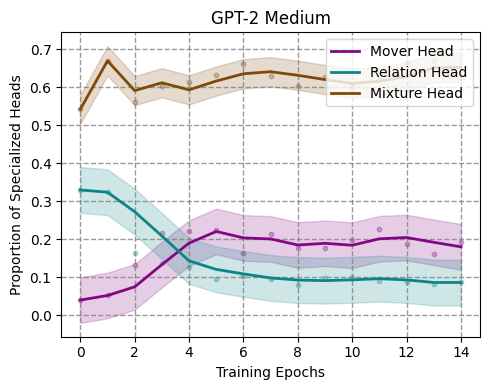

In [34]:
# 计算每个集合的元素个数
subject_head_count = [len(s) / g.count_included_nodes() for s, g in zip(circuit_subject_head_set_list, graph[task][type][freq])]
relation_head_count = [len(s) / g.count_included_nodes() for s, g in zip(circuit_relation_head_set_list, graph[task][type][freq])]
mixed_head_count = [len(s) / g.count_included_nodes() for s, g in zip(circuit_mixed_head_set_list, graph[task][type][freq])]

x = np.arange(len(indexes))

plt.figure(figsize=(5, 4))

for y, head_name, color_cnt in zip([subject_head_count, relation_head_count, mixed_head_count], ["Mover Head", "Relation Head", "Mixture Head"], ["#830783", "#0E8585", "#7E4909"]):
    window_size = 3
    x_fit = x
    y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
    y_fit = np.array(y[:window_size-1] + y_fit.tolist())
    y_residuals = y - y_fit
    std_residuals = np.std(y_residuals)
    
    line, = plt.plot(x_fit.ravel(), y_fit, label=head_name, linewidth=2, color=color_cnt)
    plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
    
    # 绘制阴影区域，偏离值区域
    plt.fill_between(x_fit.ravel(), y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)


# 添加标签和标题
plt.title('GPT-2 Medium')
plt.xlabel("Training Epochs")
plt.ylabel("Proportion of Specialized Heads")
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
plt.legend(loc='upper right')
plt.tight_layout()
# plt.ylim(0, 0.9)
plt.show()


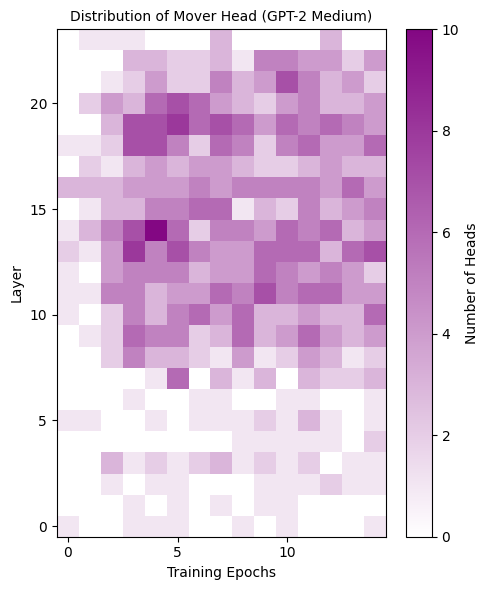

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色渐变
colors = ["#FFFFFF", "#830783"] 
cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

# 初始化二维列表，表示每个epoch中每一层出现的二元组个数
num_epochs = len(circuit_subject_head_set_list)
num_layers = analyzer.model.cfg.n_layers

# 构造二维列表
layer_count_matrix = np.zeros((num_epochs, num_layers), dtype=int)

# 填充矩阵
for epoch_idx, epoch_data in enumerate(circuit_subject_head_set_list):
    for node in epoch_data:
        layer_idx = node[0] - 1  # 假设层数从1到12，所以需要减去1来对应矩阵的索引
        layer_count_matrix[epoch_idx, layer_idx] += 1

# 交换矩阵的维度：将训练周期作为纵轴，层数作为横轴
transposed_layer_count_matrix = layer_count_matrix.T

# 绘制修改后的矩阵图
plt.figure(figsize=(5, 6))
plt.imshow(transposed_layer_count_matrix, cmap=cmap, aspect='auto', interpolation='nearest')
plt.colorbar(label="Number of Heads")

# 设置标签
plt.xticks(np.arange(0, num_epochs, 5))
plt.yticks(np.arange(0, num_layers, 5))

# 设置标题和标签
plt.title("Distribution of Mover Head (GPT-2 Medium)", fontsize=10)
plt.xlabel("Training Epochs")
plt.ylabel("Layer")

# 反转 y 轴
plt.gca().invert_yaxis()

# 显示图形
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

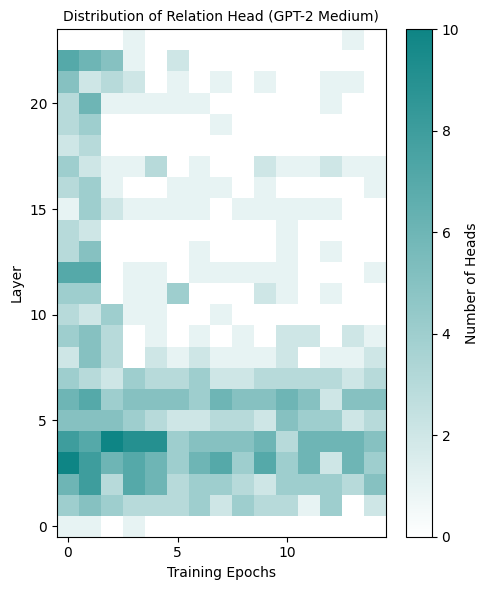

In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色渐变
colors = ["#FFFFFF", "#0E8585"]
cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

# 初始化二维列表，表示每个epoch中每一层出现的二元组个数
num_epochs = len(circuit_relation_head_set_list)
num_layers = analyzer.model.cfg.n_layers

# 构造二维列表
layer_count_matrix = np.zeros((num_epochs, num_layers), dtype=int)

# 填充矩阵
for epoch_idx, epoch_data in enumerate(circuit_relation_head_set_list):
    for node in epoch_data:
        layer_idx = node[0] - 1  # 假设层数从1到12，所以需要减去1来对应矩阵的索引
        layer_count_matrix[epoch_idx, layer_idx] += 1

# 绘制矩阵图
plt.figure(figsize=(10, 6))
# 交换矩阵的维度：将训练周期作为纵轴，层数作为横轴
transposed_layer_count_matrix = layer_count_matrix.T


# 绘制修改后的矩阵图
plt.figure(figsize=(5, 6))
plt.imshow(transposed_layer_count_matrix, cmap=cmap, aspect='auto', interpolation='nearest')
plt.colorbar(label="Number of Heads")

# 设置标签
plt.xticks(np.arange(0, num_epochs, 5))
plt.yticks(np.arange(0, num_layers, 5))

# 设置标题和标签
plt.title("Distribution of Relation Head (GPT-2 Medium)", fontsize=10)
plt.xlabel("Training Epochs")
plt.ylabel("Layer")

# 反转 y 轴
plt.gca().invert_yaxis()

# 显示图形
plt.tight_layout()
plt.show()